### Определяем необходимые библиотеки
numpy - работа с матрицами и векторами

pandas - для работы с данными

scikit-learn (sklearn) - базовая библиотека для машинного обучения

matplotlib.pyplot, seaborn - графики

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, confusion_matrix

In [2]:
def losses(y_true, y_pred):
    '''
    Данная функция вычисляет суммарный выигрыш/проигрыш исходя из заранее заданной матрицы потерь/выигрышей.
    '''
    from sklearn.metrics import confusion_matrix
    w1 = 0
    w2 = -100
    w3 = 0
    w4 = 20
    conf_matrix = confusion_matrix(y_true, y_pred)
    return w1*conf_matrix[0,0] + w2*conf_matrix[0,1] + w3*conf_matrix[1,0] + w4*conf_matrix[1,1]

In [3]:
def reward_ratio(y_true, y_pred):
    '''
    Вычисляет функцию потерь в процентах от идеального случая
    '''
    return losses(y_true, y_pred)/losses(y_true, y_true)

In [4]:
def Resampling(df, target, sampling_type = 'over', seed = 42):
    '''
    Собственная функция для выполнения процедуры по устранению дисбаланса классов.
    Имеет две стратегии работы:
    1) 'over' (по умолчанию) - выполняет oversampling (случайно копирует элементы минорного класса до достижения баланса)
    2) 'under' - выполняет undersampling (удаляет случайным образом элементы мажорного класса до достижения баланса классов)
    '''
    if sampling_type != 'over' and sampling_type != 'under': 
        raise NameError('This type of sampling is not supported') 
    if target not in df.columns: 
        raise NameError('''This column don't exist in pd.DataFrame''') 
    from sklearn.utils import resample
    major = 0
    minor = 0
    if df[target].value_counts()[0] > df[target].value_counts()[1]:
        major = 0
        minor = 1
    else:
        major = 1
        minor = 0
    df_majority = df[df[target] == major] 
    df_minority = df[df[target] == minor] 
    if sampling_type == 'over': 
        upsample = df[target].value_counts()[0] 
        df_upsampled = resample(df_minority, replace = True, n_samples = upsample, random_state = seed) 
        df2 = pd.concat([df_majority, df_upsampled]) 
        return df2 
    if sampling_type == 'under': 
        undersample = df[target].value_counts()[1] 
        df_undersampled = resample(df_majority, replace = False, n_samples = undersample, random_state = seed) 
        df2 = pd.concat([df_minority, df_undersampled]) 
        return df2

In [5]:
df = pd.read_csv('data.csv', sep = ';', index_col = 'BAN_KEY') # чтение данных

Проверим типы данных в столбцах

In [6]:
print(df.dtypes)

SUBS_KEY                    int64
AGE                       float64
GENDER                     object
PP_GROUP                   object
PP                         object
CHANNEL                    object
LTE_IND                     int64
DOUBLE_SIM                  int64
CHURN_DAYS_IND              int64
RECHARGES_SUM               int64
RECHARGES_QUANTITY          int64
VOICE1                      int64
VOICE2                      int64
VOICE3                      int64
VOICE4                      int64
VOICE5                      int64
VOICE6                      int64
VOICE7                      int64
VOICE8                      int64
VOICE9                      int64
VOICE10                     int64
VOICE11                     int64
VOICE12                     int64
VOICE13                     int64
VOICE14                     int64
VOICE15                     int64
VOICE16                     int64
VOICE17                     int64
VOICE18                     int64
VOICE19       

In [7]:
df.nunique() # проверка на количество уникальных значений в каждом столбце

SUBS_KEY                  919
AGE                        66
GENDER                      2
PP_GROUP                   25
PP                         75
CHANNEL                     8
LTE_IND                     2
DOUBLE_SIM                  2
CHURN_DAYS_IND             35
RECHARGES_SUM             233
RECHARGES_QUANTITY         27
VOICE1                      3
VOICE2                      2
VOICE3                      2
VOICE4                      4
VOICE5                      1
VOICE6                      1
VOICE7                     46
VOICE8                     46
VOICE9                    102
VOICE10                   117
VOICE11                     3
VOICE12                    11
VOICE13                    13
VOICE14                    16
VOICE15                    27
VOICE16                    40
VOICE17                    20
VOICE18                    25
VOICE19                    55
VOICE20                    44
VOICE21                   108
VOICE22                   134
VOICE23   

In [8]:
df2 = df.drop(['SUBS_KEY', 'PP'], axis = 1)

In [9]:
df2.head() # посмотрим на данные

,AGE,GENDER,PP_GROUP,CHANNEL,LTE_IND,DOUBLE_SIM,CHURN_DAYS_IND,RECHARGES_SUM,RECHARGES_QUANTITY,VOICE1,...,VOICE22,VOICE23,VOICE24,UNIQUE_SUBS_CALLED_OUT,UNIQUE_SUBS_CALLED_IN,DATA_TRAFFIC,DATA_REVENUE,MESSAGE_REVENUE,VOICE_REVENUE,VAS_REVENUE
BAN_KEY,,,,,,,,,,,,,,,,,,,,,
185094600,60.0,F,PP_WELCOME,Evroset,0,0,0,500,1,0,...,0,0,0,4,6,0,0,0,12,32
185196700,48.0,M,PP_ALL3,BTS,0,0,1,0,0,0,...,0,0,0,2,2,0,0,0,0,0
351403700,42.0,M,PP_OTHER_ONNET,Evroset,1,1,0,3504,9,0,...,1,0,0,15,17,514,50,0,215,216
470555700,50.0,M,PP_WELCOME,Monobrand Franchise,0,1,31,0,0,0,...,0,0,0,2,2,0,0,0,0,0
476344900,46.0,M,PP_SEB_D3,Monobrand Franchise,0,0,4,0,0,0,...,0,0,0,2,3,0,0,0,0,0


Бинаризуем категориальные переменные

In [10]:
to_dummy = pd.get_dummies(df2[['GENDER', 'PP_GROUP', 'CHANNEL', 'LTE_IND', 'DOUBLE_SIM']], prefix = 'bin', drop_first = True)

In [11]:
df2 = df2.drop(['GENDER', 'PP_GROUP', 'CHANNEL', 'LTE_IND', 'DOUBLE_SIM'], axis = 1)

In [12]:
data = pd.concat([df2, to_dummy], axis = 1)

Определим целевую переменную для решения задачи классификации

In [13]:
data['target'] = data['CHURN_DAYS_IND'].apply(lambda x: 0 if x >= 20 else 1)
data = data.drop('CHURN_DAYS_IND', axis = 1)

### Сгенерируем новые признаки

In [14]:
data['voicevas'] = data.VOICE_REVENUE/data.VAS_REVENUE
data['rev_per_mb'] = data.DATA_REVENUE/data.DATA_TRAFFIC
data['avg_recharge'] = data.RECHARGES_SUM/data.RECHARGES_QUANTITY
data['ratio_in_out'] = data.VOICE9/data.VOICE10
data['ratio_unique_subs'] = data.UNIQUE_SUBS_CALLED_OUT/data.UNIQUE_SUBS_CALLED_IN
data = data.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

Разобьем данные на обучающую и тестовую выборку

In [15]:
X_train, X_test = train_test_split(data, test_size = 0.2, random_state = 42)

Посмотрим на корреляционную матрицу (не особо много чего понятно)

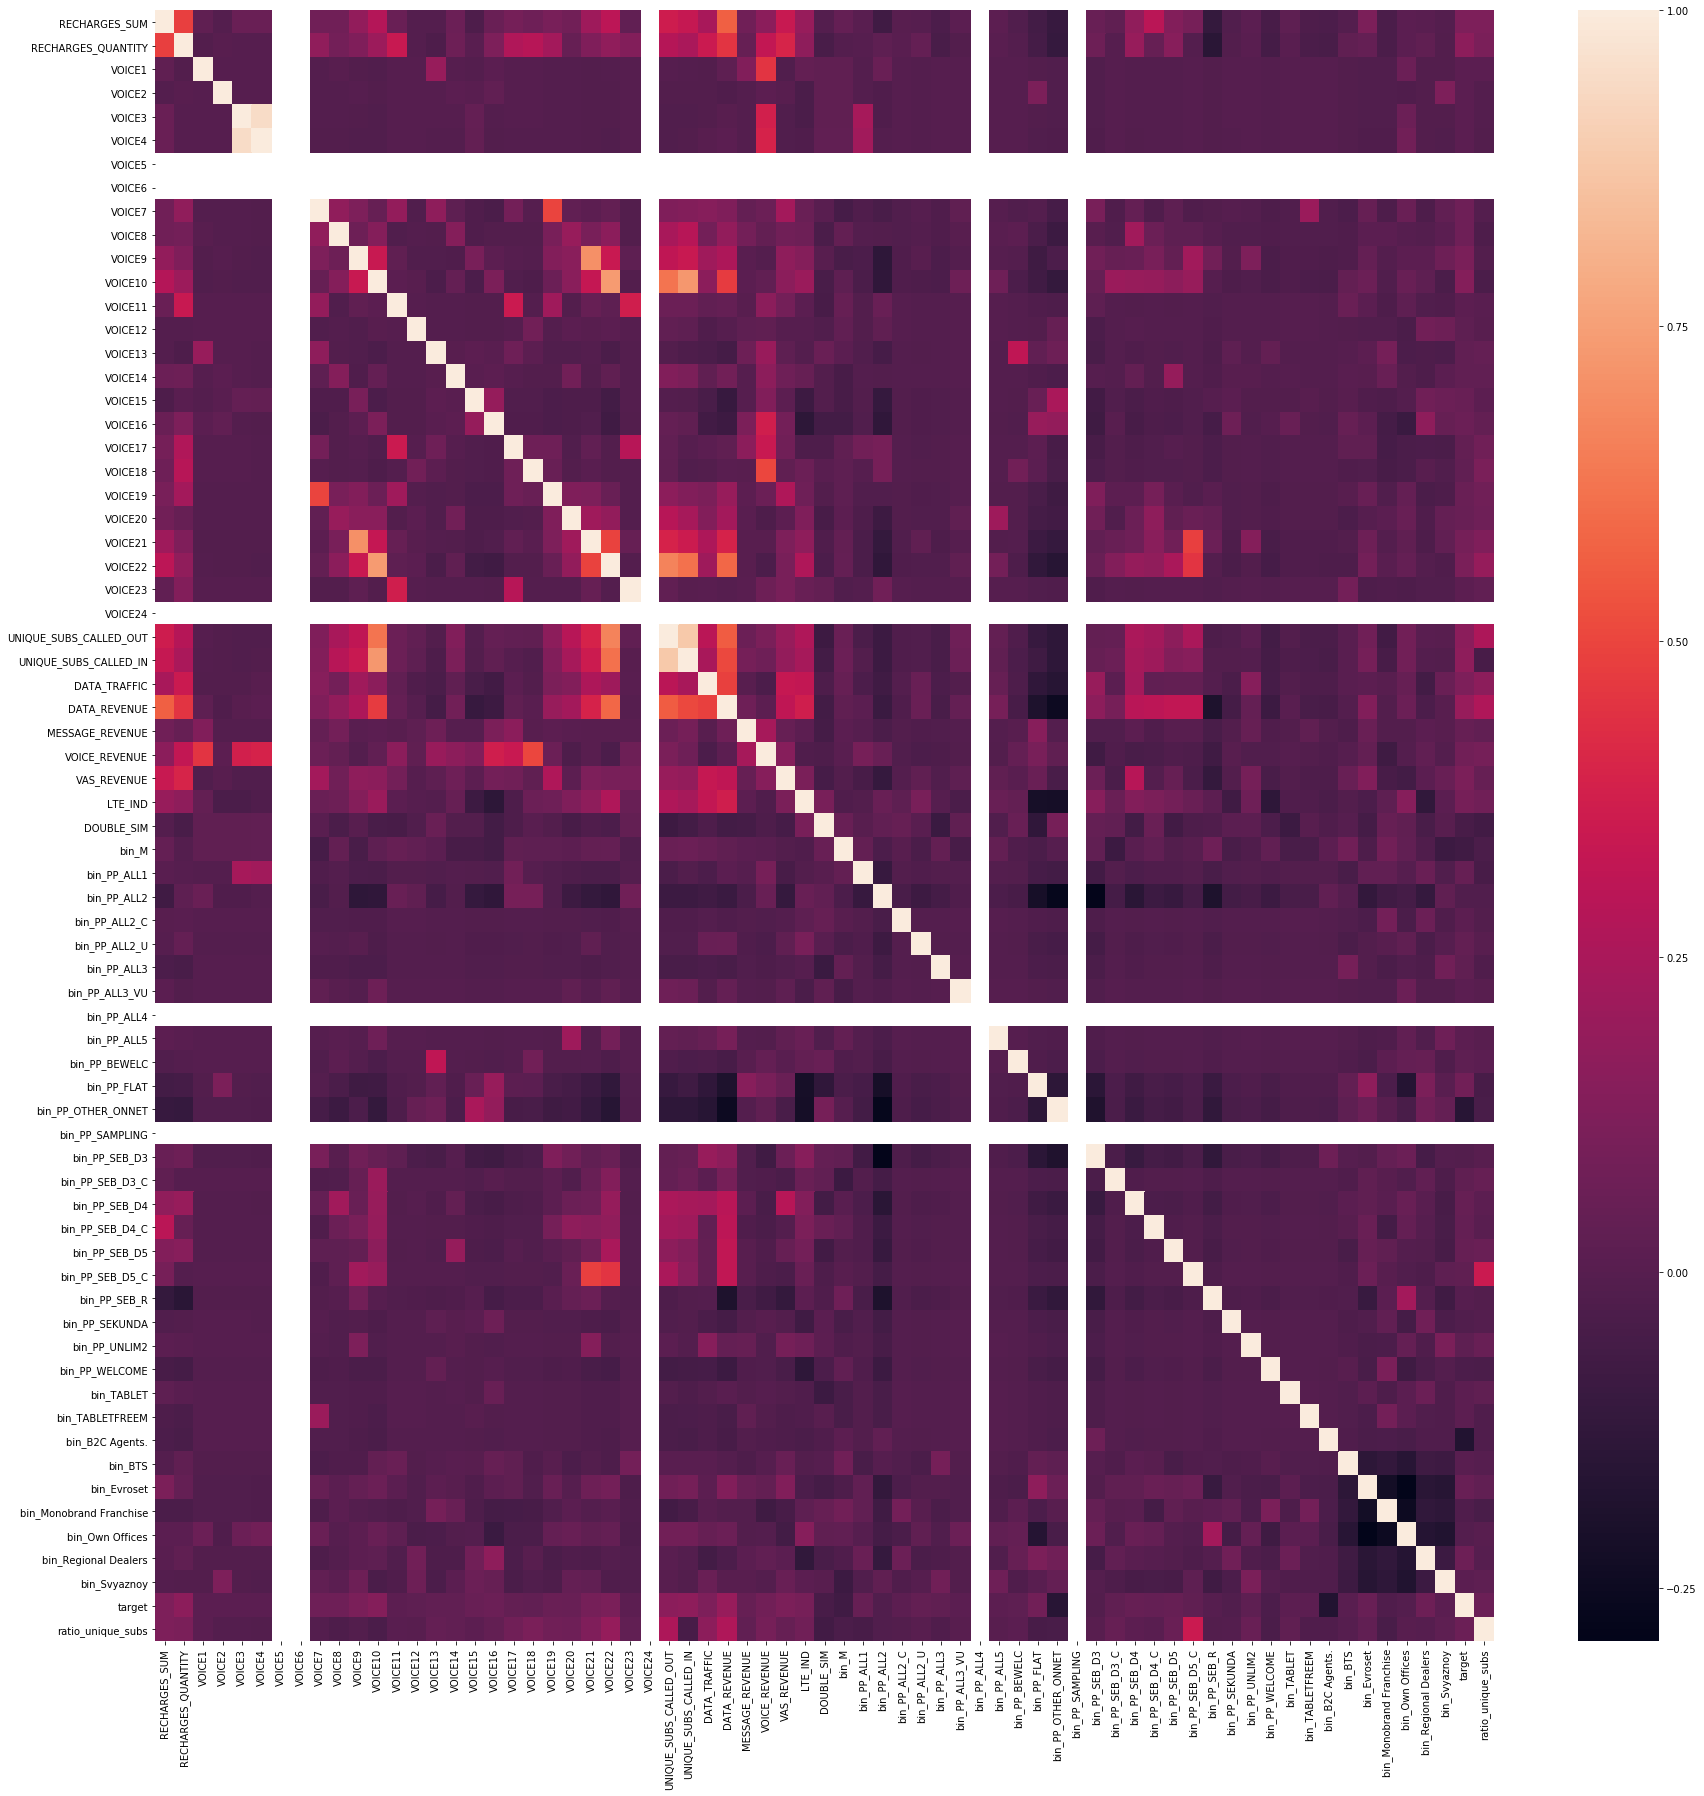

In [16]:
corr_matrix = X_train.corr()
plt.figure(figsize = (30, 30))
sns.heatmap(corr_matrix, xticklabels = X_train.columns, yticklabels = X_train.columns)

Посмотрим на 10 переменных, наиболее коррелирующих с целевой

In [17]:
corr_matrix['target'].sort_values(ascending = False)[:10]

target                    1.000000
DATA_REVENUE              0.197320
UNIQUE_SUBS_CALLED_IN     0.167678
RECHARGES_QUANTITY        0.164225
UNIQUE_SUBS_CALLED_OUT    0.159444
VOICE10                   0.139276
RECHARGES_SUM             0.121679
DATA_TRAFFIC              0.120283
VAS_REVENUE               0.112332
VOICE9                    0.111463
Name: target, dtype: float64

In [18]:
# Смотрим на баланс классов
# 595 лояльных, 140 отточников
X_train['target'].value_counts()

1    671
0     64
Name: target, dtype: int64

Подготовим обучающие наборы, избавленные от дисбаланса классов (будем сравнивать, что покажет себя лучше)

In [19]:
target = 'target'
X_train_upsampled = Resampling(X_train, target, sampling_type = 'over')
X_train_undersampled = Resampling(X_train, target, sampling_type = 'under')
y_train_upsampled = X_train_upsampled[target]
y_train_undersampled = X_train_undersampled[target]

In [20]:
train_columns = list(data.columns)
train_columns.remove(target)
y_train = X_train[target]
X_train = X_train[train_columns]
y_test = X_test[target]
X_test = X_test[train_columns]

X_train_upsampled = X_train_upsampled[train_columns]
X_train_undersampled = X_train_undersampled[train_columns]

Будем оценивать модель с помощью кросс-валидации на 5 фолдов

In [21]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

### Логистическая регрессия (без отбалансированного обучающего набора)

In [22]:
logit_model = LogisticRegression(solver = 'liblinear') # задали модель
logit_params = {'penalty': ('l1', 'l2'),
               'C': np.linspace(0.1, 5, num = 50)} # задали пространство перебора параметров
gscv = GridSearchCV(estimator = logit_model, param_grid = logit_params, scoring = 'precision', cv = kf)

imp = Imputer(strategy = 'median') # избавляемся от пропущенных значений, используем медиану как робастную величину
std = StandardScaler() # нормируем данные (приводим все в одну шкалу)
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

gscv.fit(X_train, y_train) # обучаем модель
print(gscv.best_params_)

/home/lezenith/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


{'C': 2.4000000000000004, 'penalty': 'l1'}


In [23]:
logreg = LogisticRegression(penalty = 'l1', C = 2.2, solver = 'liblinear')
logreg.fit(X_train, y_train)

LogisticRegression(C=2.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [24]:
logreg_pred_proba_train = logreg.predict_proba(X_train)[:, 1]
logreg_pred_proba_test = logreg.predict_proba(X_test)[:, 1]
logreg_pred_class_train = logreg.predict(X_train)
logreg_pred_class_test = logreg.predict(X_test)
print('AUC ROC on train = %4.2f' % roc_auc_score(y_train, logreg_pred_proba_train))
print('AUC ROC on test = %4.2f' %roc_auc_score(y_test, logreg_pred_proba_test))
print('Accuracy on train = %4.2f' %accuracy_score(y_train, logreg_pred_class_train))
print('Accuracy on test = %4.2f' %accuracy_score(y_test, logreg_pred_class_test))
print('Recall on train = %4.2f' %recall_score(y_train, logreg_pred_class_train))
print('Recall on test = %4.2f' %recall_score(y_test, logreg_pred_class_test))
print('Precision on train = %4.2f' %precision_score(y_train, logreg_pred_class_train))
print('Precision on test = %4.2f' %precision_score(y_test, logreg_pred_class_test))

AUC ROC on train = 0.92
AUC ROC on test = 0.79
Accuracy on train = 0.92
Accuracy on test = 0.92
Recall on train = 1.00
Recall on test = 0.99
Precision on train = 0.92
Precision on test = 0.93


### Логистическая регрессия (undersampling)

In [25]:
logit_model = LogisticRegression(solver = 'liblinear')
logit_params = {'penalty': ('l1', 'l2'),
               'C': np.linspace(0.1, 5, num = 50)}
gscv = GridSearchCV(estimator = logit_model, param_grid = logit_params, scoring = 'precision', cv = kf)

imp = Imputer(strategy = 'median')
std = StandardScaler()
X_train_undersampled = imp.fit_transform(X_train_undersampled)
X_test_under = imp.transform(X_test)
X_train_undersampled = std.fit_transform(X_train_undersampled)
X_test_under = std.transform(X_test_under)

gscv.fit(X_train_undersampled, y_train_undersampled)
print(gscv.best_params_)

/home/lezenith/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


{'C': 3.8000000000000003, 'penalty': 'l1'}


In [26]:
logreg = LogisticRegression(penalty = 'l1', C = 3.5, solver = 'liblinear')
logreg.fit(X_train_undersampled, y_train_undersampled)

LogisticRegression(C=3.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [27]:
logreg_pred_class_test = logreg.predict(X_test_under)

In [28]:
print('Loss function = %4.0f' % losses(y_test, logreg_pred_class_test))
print('Reward ratio = %4.2f' % reward_ratio(y_test, logreg_pred_class_test))

Loss function =  980
Reward ratio = 0.29


### Random Forest

In [29]:
rf_model = RandomForestClassifier(random_state = 42)
rf_params = {'n_estimators': list(range(10, 120, 10)),
            'max_depth': (4,5,6,7)}
gscvrf = GridSearchCV(estimator = rf_model, param_grid = rf_params, scoring = 'precision', cv = kf)
gscvrf.fit(X_train, y_train)
print(gscvrf.best_params_)

{'max_depth': 7, 'n_estimators': 40}


In [30]:
rf_model = RandomForestClassifier(n_estimators=10, max_depth=7)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [31]:
rf_pred_proba_train = rf_model.predict_proba(X_train)[:, 1]
rf_pred_proba_test = rf_model.predict_proba(X_test)[:, 1]
rf_pred_class_train = rf_model.predict(X_train)
rf_pred_class_test = rf_model.predict(X_test)
print('AUC ROC on train = %4.2f' % roc_auc_score(y_train, rf_pred_proba_train))
print('AUC ROC on test = %4.2f' %roc_auc_score(y_test, rf_pred_proba_test))
print('Accuracy on train = %4.2f' %accuracy_score(y_train, rf_pred_class_train))
print('Accuracy on test = %4.2f' %accuracy_score(y_test, rf_pred_class_test))
print('Recall on train = %4.2f' %recall_score(y_train, rf_pred_class_train))
print('Recall on test = %4.2f' %recall_score(y_test, rf_pred_class_test))
print('Precision on train = %4.2f' %precision_score(y_train, rf_pred_class_train))
print('Precision on test = %4.2f' %precision_score(y_test, rf_pred_class_test))

AUC ROC on train = 0.96
AUC ROC on test = 0.74
Accuracy on train = 0.92
Accuracy on test = 0.93
Recall on train = 1.00
Recall on test = 1.00
Precision on train = 0.92
Precision on test = 0.93


### Random Forest (undersampled)

In [32]:
rf_model = RandomForestClassifier(random_state = 42)
rf_params = {'n_estimators': list(range(10, 120, 10)),
            'max_depth': (4,5,6,7)}
gscvrf = GridSearchCV(estimator = rf_model, param_grid = rf_params, scoring = 'precision', cv = kf)
gscvrf.fit(X_train_undersampled, y_train_undersampled)
print(gscvrf.best_params_)

{'max_depth': 7, 'n_estimators': 10}


In [33]:
rf_model = RandomForestClassifier(n_estimators=10, max_depth=5)
rf_model.fit(X_train_undersampled, y_train_undersampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
rf_pred_class_test = rf_model.predict(X_test_under)

In [35]:
print('Losses = %4.0f' % losses(y_test, rf_pred_class_test))
print('Reward ratio = %4.2f' % reward_ratio(y_test, rf_pred_class_test))

Losses = 2120
Reward ratio = 0.62


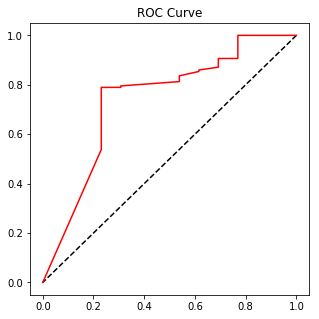

In [36]:
from sklearn.metrics import roc_curve
fpr, tpr, mpr = roc_curve(y_test, rf_pred_proba_test)
plt.figure(figsize = (5, 5))
plt.title('ROC Curve')
plt.plot([1, 0], [1,0], linestyle = '--', color = 'black')
plt.plot(fpr, tpr, color = 'red')
plt.show()

In [37]:
importances = pd.DataFrame(rf_model.feature_importances_, index=train_columns, columns=['importance']).sort_values(by = 'importance', ascending = False)
print(importances.head(10))

                        importance
UNIQUE_SUBS_CALLED_OUT    0.192485
UNIQUE_SUBS_CALLED_IN     0.107377
VOICE9                    0.097366
VOICE10                   0.073439
bin_PP_OTHER_ONNET        0.059345
DATA_REVENUE              0.056515
VAS_REVENUE               0.052721
RECHARGES_QUANTITY        0.049128
RECHARGES_SUM             0.041037
ratio_unique_subs         0.038305


# KNN

In [38]:
KNN = KNeighborsClassifier()
knn_params = {'n_neighbors': range(1, 30)}
gscvknn = GridSearchCV(estimator = KNN, param_grid = knn_params, scoring = 'precision', cv = kf)
gscvknn.fit(X_train, y_train)
print(gscvknn.best_params_)

{'n_neighbors': 2}


In [39]:
KNN_model = KNeighborsClassifier(n_neighbors=2)
KNN_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [40]:
knn_pred_proba_train = KNN_model.predict_proba(X_train)[:, 1]
knn_pred_proba_test = KNN_model.predict_proba(X_test)[:, 1]
knn_pred_class_train = KNN_model.predict(X_train)
knn_pred_class_test = KNN_model.predict(X_test)
print('AUC ROC on train = %4.2f' % roc_auc_score(y_train, knn_pred_proba_train))
print('AUC ROC on test = %4.2f' %roc_auc_score(y_test, knn_pred_proba_test))
print('Accuracy on train = %4.2f' %accuracy_score(y_train, knn_pred_class_train))
print('Accuracy on test = %4.2f' %accuracy_score(y_test, knn_pred_class_test))
print('Recall on train = %4.2f' %recall_score(y_train, knn_pred_class_train))
print('Recall on test = %4.2f' %recall_score(y_test, knn_pred_class_test))
print('Precision on train = %4.2f' %precision_score(y_train, knn_pred_class_train))
print('Precision on test = %4.2f' %precision_score(y_test, knn_pred_class_test))

AUC ROC on train = 0.89
AUC ROC on test = 0.50
Accuracy on train = 0.90
Accuracy on test = 0.79
Recall on train = 0.91
Recall on test = 0.84
Precision on train = 0.98
Precision on test = 0.93


### KNN (undersampling)

In [41]:
KNN = KNeighborsClassifier()
knn_params = {'n_neighbors': range(1, 30)}
gscvknn = GridSearchCV(estimator = KNN, param_grid = knn_params, scoring = 'precision', cv = kf)
gscvknn.fit(X_train_undersampled, y_train_undersampled)
print(gscvknn.best_params_)

{'n_neighbors': 2}


In [42]:
KNN_model = KNeighborsClassifier(n_neighbors=2)
KNN_model.fit(X_train_undersampled, y_train_undersampled)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [43]:
knn_pred_class_test = KNN_model.predict(X_test_under)

In [44]:
print('Losses = %4.0f' % losses(y_test, knn_pred_class_test))
print('Reward ratio = %4.2f' % reward_ratio(y_test, knn_pred_class_test))

Losses = 1640
Reward ratio = 0.48
